# Dataset 1 Notebook: for analyzing 'EpiOnly_20180710'

## Import Necessary Packages & Read in Data

In [1]:
#Basic Packages
import os
import random
import copy
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) # display all the columns
import scipy.stats as scs
from scipy.stats import randint
import warnings
warnings.filterwarnings('ignore')

#Visualization Packages:
%matplotlib inline   
import matplotlib.pyplot as plt

#Import Progress bar
from tqdm import tnrange, tqdm_notebook

#Imputation Packages:
from fancyimpute import KNN

#Scikit-Learn Packages:
from sklearn.feature_selection import mutual_info_classif
from skrebate import MultiSURF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import datasets

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import xgboost as xgb

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Set a random seed for the notebook so that individual runs of the notebook yield the same results
randSeed = 42 #changing this value will potentially change the models and results due to stochastic elements of the pipeline. 
np.random.seed(randSeed)

Using TensorFlow backend.


## Specify dataset specific paths/names
This should be the only section/cell in this notebook that is customized to the specific dataset. It may be necessary to change the names and paths to point this notebook to the 

In [2]:
#unique dataset name (target data for this analysis)
data_name = 'EpiOnly_20180710_Clean' 

#path to where original data and pre-CV partitioned datasets are stored
data_path = 'C:/home/work/research_collab/Lynch_Bias_ML_Pancreatic/Datasets/Final Data/'

#path to where this notebooks output files will be saved
out_path =  'C:/home/work/research_collab/Lynch_Bias_ML_Pancreatic/Final Materials/results/notebook_output/' 

#path wehere
multisurf_path = 'C:/home/work/research_collab/Lynch_Bias_ML_Pancreatic/Final Materials/results/cluster/multisurf/'

orig_data = data_path+data_name+'.txt'
print(orig_data)

cv_path = data_path+'CV/'
cv_type = 'CV_S'
cv_data = cv_path+data_name+'_InstLab_'+cv_type+'_'
multisurf_name = 'MultiSURF_'+data_name+'_'+cv_type+'_'

cv = 10
number_of_algorithms = 7 #logisticregression, decisiontree, randomforest, ann, xgboost, svm, naivebayes,- lcs will be added externally


C:/home/work/research_collab/Lynch_Bias_ML_Pancreatic/Datasets/Final Data/EpiOnly_20180710_Clean.txt


## Load Original Dataset

In [3]:
td = pd.read_csv(orig_data, na_values='NA', sep = "\t") #Data loaded so that blank excell cells are 'NA'
td.shape #Reports the number of (rows,columns)

(5098, 24)

In [4]:
num_instances = td.shape[0]
print('Dataset contains '+str(num_instances)+' instances.')
num_features = td.shape[1] - 1
print('Dataset contains '+str(num_features)+' features plus 1 class/outcome.')

Dataset contains 5098 instances.
Dataset contains 23 features plus 1 class/outcome.


In [5]:
#Specify outcome variable name
outcome_name = 'panc_type01'

# Exploratory Analysis

In the first section of this notebook, we will read in the data, which has been pre-partitioned into 10 testing and training cross validation sets. We will then conduct various methods of data exploration in order to "get to know" our data for things like dimensions, attributes, statistical features, data imbalance, and missingness.

In [6]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5098 entries, 0 to 5097
Data columns (total 24 columns):
panc_type01          5098 non-null float64
cig_stat             5069 non-null float64
cig_stop             2946 non-null float64
cig_years            5000 non-null float64
pack_years           4997 non-null float64
bmi_curc             5015 non-null float64
bmi_curr             5015 non-null float64
diabetes_f           5050 non-null float64
panc_fh              5022 non-null float64
fh_cancer            5057 non-null float64
bmi_20               4998 non-null float64
bmi_50               5019 non-null float64
asp                  5038 non-null float64
ibup                 5053 non-null float64
gallblad_f           5053 non-null float64
liver_comorbidity    5048 non-null float64
age                  5098 non-null int64
agelevel             5098 non-null int64
educat               5064 non-null float64
race7                5098 non-null int64
total_Marital        5070 non-null floa

In [7]:
#Examine the number of unique values for each variable/feature. Note that missing values are not being include as unique values. 
unique_count = td.nunique()
unique_count

panc_type01             2
cig_stat                3
cig_stop               54
cig_years              62
pack_years            174
bmi_curc                4
bmi_curr             1279
diabetes_f              2
panc_fh                 3
fh_cancer               2
bmi_20                776
bmi_50                924
asp                     2
ibup                    2
gallblad_f              2
liver_comorbidity       2
age                    20
agelevel                4
educat                  7
race7                   7
total_Marital           5
center                 10
rndyear                 9
sex                     2
dtype: int64

In [8]:
#Evaluate missingness and data availability
print("Missing Value Counts")
missing_count = td.isnull().sum()
missing_count

Missing Value Counts


panc_type01             0
cig_stat               29
cig_stop             2152
cig_years              98
pack_years            101
bmi_curc               83
bmi_curr               83
diabetes_f             48
panc_fh                76
fh_cancer              41
bmi_20                100
bmi_50                 79
asp                    60
ibup                   45
gallblad_f             45
liver_comorbidity      50
age                     0
agelevel                0
educat                 34
race7                   0
total_Marital          28
center                  0
rndyear                 0
sex                     0
dtype: int64

### Assess Class imbalance


Counts of each class
0.0    4298
1.0     800
Name: panc_type01, dtype: int64


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Class Counts (Checking for Imbalance)')

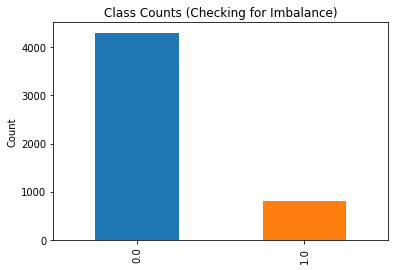

In [9]:
print("Counts of each class")
print(td[outcome_name].value_counts())
td[outcome_name].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Class Counts (Checking for Imbalance)')

## Load CV partition datasets

In [10]:
#create lists to hold training and testing set dataframes.
trainList = []
testList = []
for i in range(cv):
    #Load training partition
    trainset_name = cv_data+str(i)+'_Train.txt'
    trainSet = pd.read_csv(trainset_name, na_values='NA', sep = "\t")
    trainList.append(trainSet)
    
    #Load testing partition
    testset_name = cv_data+str(i)+'_Test.txt'
    testSet = pd.read_csv(testset_name, na_values='NA', sep = "\t")
    testList.append(testSet)
    
print(len(trainList))
print(len(testList))

10
10


In [11]:
#Confirm case/control counts when merging one training and testing dataset
classesTrain = trainList[0].apply(lambda x: True if x['panc_type01'] == 1 else False , axis=1)
casesTrain = len(classesTrain[classesTrain == True].index)
controlsTrain = len(classesTrain[classesTrain == False].index)

classesTest = testList[0].apply(lambda x: True if x['panc_type01'] == 1 else False , axis=1)
casesTest = len(classesTest[classesTest == True].index)
controlsTest = len(classesTest[classesTest == False].index)

print(casesTrain+casesTest)
print(controlsTrain+controlsTest)

800
4298


In [12]:
#Confirm training and testing set dimensions
print("Training Set Dimensions: " + str(trainList[0].shape))
print("Testing Set Dimensions: " + str(testList[0].shape))

Training Set Dimensions: (4588, 25)
Testing Set Dimensions: (510, 25)


## Partition data cleaning

In [13]:
# Drop 'plco_id' feature from all training and test sets
for i in range(10):
    trainList[i] = trainList[i].drop(['plco_id'] , axis = 1)
    testList[i] = testList[i].drop(['plco_id'] , axis = 1)

In [14]:
trainColumnNames = list(trainList[0])
testColumnNames = list(testList[0])

# As we can see, 'plco_id' is no longer a column name for any of the sets
print(trainColumnNames)
print(testColumnNames)

ordered_feature_names = copy.deepcopy(trainColumnNames)
ordered_feature_names.remove(outcome_name)
ordered_feature_names

['panc_type01', 'cig_stat', 'cig_stop', 'cig_years', 'pack_years', 'bmi_curc', 'bmi_curr', 'diabetes_f', 'panc_fh', 'fh_cancer', 'bmi_20', 'bmi_50', 'asp', 'ibup', 'gallblad_f', 'liver_comorbidity', 'age', 'agelevel', 'educat', 'race7', 'total_Marital', 'center', 'rndyear', 'sex']
['panc_type01', 'cig_stat', 'cig_stop', 'cig_years', 'pack_years', 'bmi_curc', 'bmi_curr', 'diabetes_f', 'panc_fh', 'fh_cancer', 'bmi_20', 'bmi_50', 'asp', 'ibup', 'gallblad_f', 'liver_comorbidity', 'age', 'agelevel', 'educat', 'race7', 'total_Marital', 'center', 'rndyear', 'sex']


['cig_stat',
 'cig_stop',
 'cig_years',
 'pack_years',
 'bmi_curc',
 'bmi_curr',
 'diabetes_f',
 'panc_fh',
 'fh_cancer',
 'bmi_20',
 'bmi_50',
 'asp',
 'ibup',
 'gallblad_f',
 'liver_comorbidity',
 'age',
 'agelevel',
 'educat',
 'race7',
 'total_Marital',
 'center',
 'rndyear',
 'sex']

### Impute missing values

In [15]:
# Convert each of the datasets into matrices to prepare for imputation
for i in range(10):
    trainList[i] = trainList[i].as_matrix()
    testList[i] = testList[i].as_matrix()
trainList[0].shape
testList[0].shape

(4588, 24)

(510, 24)

In [16]:
# Impute missing data using K-Nearest Neighbors imputation algorithm
for i in range(10):
    trainList[i] = pd.DataFrame(KNN(3).fit_transform(trainList[i]))
    trainList[i].columns = trainColumnNames
    
    testList[i] = pd.DataFrame(KNN(3).fit_transform(testList[i]))
    testList[i].columns = testColumnNames
trainList[0].shape
testList[0].shape

Imputing row 1/4588 with 1 missing, elapsed time: 4.491
Imputing row 101/4588 with 1 missing, elapsed time: 4.499
Imputing row 201/4588 with 1 missing, elapsed time: 4.507
Imputing row 301/4588 with 0 missing, elapsed time: 4.516
Imputing row 401/4588 with 1 missing, elapsed time: 4.524
Imputing row 501/4588 with 1 missing, elapsed time: 4.530
Imputing row 601/4588 with 0 missing, elapsed time: 4.535
Imputing row 701/4588 with 0 missing, elapsed time: 4.539
Imputing row 801/4588 with 0 missing, elapsed time: 4.542
Imputing row 901/4588 with 1 missing, elapsed time: 4.549
Imputing row 1001/4588 with 0 missing, elapsed time: 4.555
Imputing row 1101/4588 with 1 missing, elapsed time: 4.559
Imputing row 1201/4588 with 0 missing, elapsed time: 4.563
Imputing row 1301/4588 with 0 missing, elapsed time: 4.567
Imputing row 1401/4588 with 0 missing, elapsed time: 4.572
Imputing row 1501/4588 with 1 missing, elapsed time: 4.577
Imputing row 1601/4588 with 0 missing, elapsed time: 4.581
Imputing 

Imputing row 3501/4588 with 1 missing, elapsed time: 4.656
Imputing row 3601/4588 with 1 missing, elapsed time: 4.661
Imputing row 3701/4588 with 1 missing, elapsed time: 4.666
Imputing row 3801/4588 with 4 missing, elapsed time: 4.669
Imputing row 3901/4588 with 0 missing, elapsed time: 4.673
Imputing row 4001/4588 with 0 missing, elapsed time: 4.677
Imputing row 4101/4588 with 1 missing, elapsed time: 4.683
Imputing row 4201/4588 with 0 missing, elapsed time: 4.687
Imputing row 4301/4588 with 1 missing, elapsed time: 4.690
Imputing row 4401/4588 with 0 missing, elapsed time: 4.694
Imputing row 4501/4588 with 0 missing, elapsed time: 4.698
Imputing row 1/510 with 0 missing, elapsed time: 0.066
Imputing row 101/510 with 0 missing, elapsed time: 0.071
Imputing row 201/510 with 0 missing, elapsed time: 0.074
Imputing row 301/510 with 0 missing, elapsed time: 0.077
Imputing row 401/510 with 1 missing, elapsed time: 0.081
Imputing row 501/510 with 0 missing, elapsed time: 0.088
Imputing ro

Imputing row 1901/4588 with 1 missing, elapsed time: 4.598
Imputing row 2001/4588 with 0 missing, elapsed time: 4.603
Imputing row 2101/4588 with 1 missing, elapsed time: 4.608
Imputing row 2201/4588 with 0 missing, elapsed time: 4.612
Imputing row 2301/4588 with 1 missing, elapsed time: 4.615
Imputing row 2401/4588 with 0 missing, elapsed time: 4.619
Imputing row 2501/4588 with 17 missing, elapsed time: 4.624
Imputing row 2601/4588 with 2 missing, elapsed time: 4.629
Imputing row 2701/4588 with 0 missing, elapsed time: 4.633
Imputing row 2801/4588 with 1 missing, elapsed time: 4.637
Imputing row 2901/4588 with 0 missing, elapsed time: 4.640
Imputing row 3001/4588 with 0 missing, elapsed time: 4.644
Imputing row 3101/4588 with 0 missing, elapsed time: 4.647
Imputing row 3201/4588 with 0 missing, elapsed time: 4.651
Imputing row 3301/4588 with 0 missing, elapsed time: 4.654
Imputing row 3401/4588 with 1 missing, elapsed time: 4.659
Imputing row 3501/4588 with 1 missing, elapsed time: 4.

Imputing row 201/4589 with 1 missing, elapsed time: 4.515
Imputing row 301/4589 with 0 missing, elapsed time: 4.519
Imputing row 401/4589 with 1 missing, elapsed time: 4.523
Imputing row 501/4589 with 1 missing, elapsed time: 4.529
Imputing row 601/4589 with 1 missing, elapsed time: 4.534
Imputing row 701/4589 with 1 missing, elapsed time: 4.538
Imputing row 801/4589 with 0 missing, elapsed time: 4.542
Imputing row 901/4589 with 0 missing, elapsed time: 4.547
Imputing row 1001/4589 with 0 missing, elapsed time: 4.552
Imputing row 1101/4589 with 0 missing, elapsed time: 4.557
Imputing row 1201/4589 with 0 missing, elapsed time: 4.561
Imputing row 1301/4589 with 1 missing, elapsed time: 4.567
Imputing row 1401/4589 with 3 missing, elapsed time: 4.571
Imputing row 1501/4589 with 17 missing, elapsed time: 4.576
Imputing row 1601/4589 with 0 missing, elapsed time: 4.582
Imputing row 1701/4589 with 1 missing, elapsed time: 4.586
Imputing row 1801/4589 with 0 missing, elapsed time: 4.590
Impu

(4588, 24)

(510, 24)

### Format data for Scikit learn (separate features from outcome)

In [17]:
# Separate data into training and test features and outcomes
xTrainList = []
yTrainList = []
xTestList = []
yTestList = []

for i in range(10):
    xTrainList.append(trainList[i].iloc[:, 1:].values)
    yTrainList.append(trainList[i].iloc[:, 0].values)
    
    xTestList.append(testList[i].iloc[:, 1:].values)
    yTestList.append(testList[i].iloc[:, 0].values)


## Pipeline Design Strategy
- let's break this pipeline up by ML method so we run through and collect results from FS to Modeling for all CVs for just one method at a time. Create a feature selection def() to call in each. 
- each run will output saved stats and FI results (on a per Modeler basis)
- Then at the end we will collect all results to generate feature importance figures and summaries

# Feature Selection/Weighting

In this section, we will demonstrate various feature processing methods in order to determine the importance/necessity of each of the features that describe the datasets.
- for target training set we will run each method and save Feature importance scores
- then we will examine the union of the two sets to determine which features will be preserved (report counts)
- no need to visualize all these results here since they are on a per-training set basis

In [18]:
def feature_selection(xTrain, yTrain, cv_count):
    
    #Run mutual information algorithm
    mi_results = mutual_info_classif(xTrain, yTrain, random_state=randSeed)
    print(mi_results)
    
    #Run multisurf
    filename = multisurf_path+multisurf_name+str(cv_count)+'_Train.txt'

    #*********************************************************************    
    multisurf_results = []
    
    try:
        fileObject = open(filename, 'r')  # opens each datafile to read.
        #Create Dictionary of scores
        scoreDict = {}
        counter = 0
        for line in fileObject:
            if counter < 3: #ignore the first three rows (Relief-file format)
                pass
            else:
                tempList = line.strip().split('\t')
                scoreDict[tempList[0]] = float(tempList[1]) #all attributes and corresponding EK scores are hashed in a dictionary
            counter += 1

        #Reorganize scores in original feature order
        for i in ordered_feature_names:
            multisurf_results.append(scoreDict[i])

    except:
        print(filename)
        print("Data-set Not Found! Running MultiSURF locally.")

        clf = MultiSURF().fit(xTrain, yTrain)
        multisurf_results = clf.feature_importances_

    print(multisurf_results)
    #*********************************************************************  

    #Get names of features with values over 0
    trainFeatureNames = copy.deepcopy(trainColumnNames)
    trainFeatureNames.remove(outcome_name)

    mi_names = []
    j=0
    for i in mi_results:
        if i > 0.0:
            mi_names.append(trainFeatureNames[j])
        j+=1 

    multisurf_names = []
    j=0
    for i in multisurf_results:
        if i > 0.0:
            multisurf_names.append(trainFeatureNames[j])
        j+=1 

    #Union approach to selecting features to be passed on for modeling
    selected_feature_names = []
    for each in trainFeatureNames:
        if each in multisurf_names or each in mi_names:
            selected_feature_names.append(each)

    print(selected_feature_names)

    #Make list of column indexes corresponding to this union of names
    selected_indexes = []
    for i in selected_feature_names:
        selected_indexes.append(trainFeatureNames.index(i))
    print(selected_indexes)
    print(len(selected_indexes))

    return selected_feature_names, selected_indexes

## Run Feature selection for all CV partitions and create new Train/test feature value sets

In [19]:
#Go through each CV partition, run FS and create a new set of Train/test sets to be used by all methods. 
selected_feature_list =[]
selected_index_list = []

xTrainListFS = []
xTestListFS = []

for i in tqdm_notebook(range(cv), desc='1st loop'):
    #Run feature selection
    selected_feature_names, selected_indexes = feature_selection(xTrainList[i],yTrainList[i], i)
    
    #Store feature sets from each CV
    selected_feature_list.append(selected_feature_names)
    selected_index_list.append(selected_indexes)
    
    #Create training and testing data subsets (only selected features)
    xTrainFS = pd.DataFrame(xTrainList[i])
    xTrainListFS.append(xTrainFS.iloc[: , selected_indexes].values)

    xTestFS = pd.DataFrame(xTestList[i])
    xTestListFS.append(xTestFS.iloc[: , selected_indexes].values)

[0.00752742 0.00185818 0.01068426 0.0094486  0.00374256 0.00799695
 0.00936373 0.00353205 0.01577978 0.01593836 0.00411806 0.00620052
 0.00633845 0.00549126 0.00129907 0.         0.         0.00321422
 0.0140084  0.00884869 0.00583111 0.00899706 0.02868134]
[-0.00296128375096, 0.000234911496626, -0.00460204389349, 0.00213658398813, -0.0094417294386, -0.0035561016363, 0.00367781557704, 0.00423268205924, -0.00913883400334, -0.00616772066664, 0.00178063293373, -0.0108819546645, -0.00524734913773, 0.00789012474289, -0.00178056081952, -0.00900989091936, -0.0134354324189, -0.0113360537081, 0.0184082036249, -0.000434846742522, -0.00439027386201, -0.0103047429528, 0.0816701393187]
['cig_stat', 'cig_stop', 'cig_years', 'pack_years', 'bmi_curc', 'bmi_curr', 'diabetes_f', 'panc_fh', 'fh_cancer', 'bmi_20', 'bmi_50', 'asp', 'ibup', 'gallblad_f', 'liver_comorbidity', 'educat', 'race7', 'total_Marital', 'center', 'rndyear', 'sex']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21,

 0.02021797 0.0023406  0.00823703 0.         0.02481095]
[-0.00484662769023, -0.00164976438853, -0.00716220770255, 0.0027545831532, -0.00980096594157, -0.00327482389958, 0.00413105854628, 0.00595389023139, -0.0101123700337, -0.00570443190444, 0.0038401291586, -0.0110962272042, -0.00765906786182, 0.00938692079758, -0.00162249481484, -0.00965175029465, -0.01415596633, -0.0109789351206, 0.0204740559135, -0.000308882458466, -0.00350354578994, -0.00991898858864, 0.0861427547433]
['cig_stat', 'cig_stop', 'cig_years', 'pack_years', 'bmi_curc', 'bmi_curr', 'diabetes_f', 'panc_fh', 'fh_cancer', 'bmi_20', 'bmi_50', 'asp', 'ibup', 'gallblad_f', 'liver_comorbidity', 'race7', 'total_Marital', 'center', 'sex']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19, 20, 22]
19
[0.00952115 0.         0.00726579 0.00215747 0.0085556  0.01160081
 0.01073794 0.00312731 0.01804815 0.01054792 0.01784293 0.0075686
 0.0088407  0.         0.00413776 0.         0.         0.00845194
 0.02424367 0.00408356 0

## Function to save performance results for machine learner.

In [20]:
def save_performance(algorithm, tp_tmp,tn_tmp,fp_tmp,fn_tmp,acc_tmp,bacc_tmp,rec_tmp,spec_tmp,prec_tmp,f1_tmp):
    
    results = {'TP':tp_tmp, 'TN':tn_tmp, 'FP':fp_tmp, 'FN':fn_tmp, 'Accuracy':acc_tmp, 'Balanced Accuracy':bacc_tmp, 
              'Recall':rec_tmp, 'Specificity':spec_tmp, 'Precision':prec_tmp, 'F1_Score':f1_tmp}

    dr = pd.DataFrame(results)
    
    filepath = out_path+data_name+'_'+algorithm+'_metrics.csv'
    dr.to_csv(filepath, header=True, index=False)  

In [21]:
def save_FI(FI_all):
    
    dr = pd.DataFrame(FI_all)
    filepath = out_path+data_name+'_'+algorithm+'_FI.csv'
    dr.to_csv(filepath, header=ordered_feature_names, index=False)  


## Logistic Regression Modeling

In [22]:
algorithm = 'logistic_regression'

#Define hyperparameters and associated values to be explored in grid search

#param_grid = {"penalty": ['l2'], "max_iter": [100], "C": [1.0]} #Default hyperparameters for local testing
param_grid = {"penalty": ['l1', 'l2'], "max_iter": [100, 1000], "C": [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]}

tp_tmp = []
tn_tmp = []
fp_tmp = []
fn_tmp = []
acc_tmp = []
bacc_tmp = []
rec_tmp = [] #aka sensitivity
spec_tmp = []
prec_tmp = []
f1_tmp = []

FI_temp = [0]*num_features
FI_all = []
print(len(FI_temp))

for i in tqdm_notebook(range(cv), desc='1st loop'):

    #t_xTrainData = xTrainList[i]
    #t_xTestData = xTestList[i]
    t_xTrainData = xTrainListFS[i]
    t_xTestData = xTestListFS[i]
    
    #Run Hyperparameter sweep
    clf = LogisticRegression(random_state = randSeed)
    search = GridSearchCV(estimator=clf, n_jobs = -1, param_grid=param_grid, scoring='balanced_accuracy')
    search.fit(t_xTrainData, yTrainList[i])
    #print(search.best_score_)
    print(search.best_params_)
    
    #Train model using 'best' hyperparameters - Uses default 3-fold internal CV (training/validation splits)
    clf = LogisticRegression(random_state = randSeed, n_jobs = -1, penalty=search.best_params_['penalty'],max_iter=search.best_params_['max_iter'],C=search.best_params_['C'])
    model = clf.fit(t_xTrainData, yTrainList[i])
    
    #Prediction evaluation
    yPred = clf.predict(t_xTestData)
    
    #calculate and store evaluation metrics
    tn, fp, fn, tp = confusion_matrix(yTestList[i], yPred).ravel()
    tp_tmp.append(tp)
    tn_tmp.append(tn)
    fp_tmp.append(fp)
    fn_tmp.append(fn)
    
    acc_tmp.append(accuracy_score(yTestList[i], yPred))
    bacc_tmp.append(balanced_accuracy_score(yTestList[i], yPred))
    rec_tmp.append(recall_score(yTestList[i], yPred)) #aka sensitivity
    prec_tmp.append(precision_score(yTestList[i], yPred))
    f1_tmp.append(f1_score(yTestList[i], yPred))
    
    #calculate specificity
    if tn == 0 and fp == 0:
        spec = 0
    else:
        spec = tn/float(tn+fp)
    spec_tmp.append(spec)
        
    #obtain and store feature importance scores
    print("\n---Feature Importances---\n")
    LRImp = np.exp(clf.coef_[0])
    print(LRImp)
    print(len(LRImp))

    
    #sum feature importance scores across CVs
    score_count = 0
    tempList = []
    for j in range(0,num_features):
        if j in selected_index_list[i]:
            FI_temp[j] += LRImp[score_count]
            tempList.append(LRImp[score_count])
            score_count += 1

        else:
            tempList.append(0)
            
    FI_all.append(tempList)
    
    #for k, v in sorted(zip(map(lambda x: round(x, 4), LRImp), trainList[0].iloc[:, 1:].columns), reverse=True):
    #    print (v + ": " + str(k))

print(FI_temp)

#Calculate average feature importance scores
for i in range(0,len(FI_temp)):
    FI_temp[i] = FI_temp[i]/float(cv)

print('---------------------------------------------------------')
print(FI_temp)
print(len(FI_temp))
print('---------------------------------------------------------')

#Save performance metrics to file
save_performance(algorithm, tp_tmp,tn_tmp,fp_tmp,fn_tmp,acc_tmp,bacc_tmp,rec_tmp,spec_tmp,prec_tmp,f1_tmp)

#save feature importance scores to file
save_FI(FI_all)

#-------------------------------------------------------------------
print("Avg. Model Balanced Accuracy = " + str(np.mean(bacc_tmp)) +
     " (std. dev. = " + str(np.std(bacc_tmp)) + ")")    
print("Avg. Model Accuracy = " + str(np.mean(acc_tmp)) +
      " (std. dev. = " + str(np.std(acc_tmp)) + ")")
print("Avg. Model Specificity = " + str(np.mean(spec_tmp)) +
     " (std. dev. = " + str(np.std(spec_tmp)) + ")")
print("Avg. Model Recall = " + str(np.mean(rec_tmp)) +
     " (std. dev. = " + str(np.std(rec_tmp)) + ")")
print("Avg. Model Precision = " + str(np.mean(prec_tmp)) +
      " (std. dev. = " + str(np.std(prec_tmp)) + ")")
print("Avg. Model F1-Score = " + str(np.mean(f1_tmp)) +
      " (std. dev. = " + str(np.std(f1_tmp)) + ")")
print("Avg. Model True Positives = " + str(np.mean(tp_tmp)) +
      " (std. dev. = " + str(np.std(tp_tmp)) + ")")
print("Avg. Model True Negatives = " + str(np.mean(tn_tmp)) +
      " (std. dev. = " + str(np.std(tn_tmp)) + ")")
print("Avg. Model False Positives = " + str(np.mean(fp_tmp)) +
      " (std. dev. = " + str(np.std(fp_tmp)) + ")")
print("Avg. Model False Negatives = " + str(np.mean(fn_tmp)) +
      " (std. dev. = " + str(np.std(fn_tmp)) + ")")
    

23


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000], 'max_iter': [100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'C': 100, 'penalty': 'l2', 'max_iter': 100}

---Feature Importances---

[0.80947638 0.99126263 1.00588204 1.00573927 0.97709011 0.99601468
 1.22662874 0.97421061 1.26241539 1.04636298 0.98947489 1.03505013
 0.98756118 1.41982223 1.03383552 0.99428903 1.63614534 0.9760601
 0.96755702 0.9977526  4.52783571]
21


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000], 'max_iter': [100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'C': 10, 'penalty': 'l1', 'max_iter': 100}

---Feature Importances---

[0.79214709 1.01635773 1.00434574 1.1432493  0.96569445 1.46212094
 0.98811314 1.23063681 1.03300603 1.00281479 1.01055009 0.93017251
 1.38954874 0.99337901 1.06098473 0.99302314 1.60983679 1.00026296
 0.95475436 0.99783526 4.72458467]
21


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000], 'max_iter': [100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'C': 1000, 'penalty': 'l2', 'max_iter': 100}

---Feature Importances---

[0.7936766  0.98147443 1.00006226 1.005529   1.07705255 0.96784384
 1.32142797 0.98768412 1.24227377 1.03621419 1.01299677 1.04495395
 1.45451824 1.00808542 1.0322884  0.99643529 0.98918684 1.56480767
 1.01522432 0.96023149 0.99699945 4.48634685]
22


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000], 'max_iter': [100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'C': 10, 'penalty': 'l2', 'max_iter': 100}

---Feature Importances---

[0.81550893 0.97981767 0.9993368  1.00393    1.06466966 0.97787927
 1.31570703 0.97832708 1.31512691 1.0403756  0.9997666  1.00867953
 1.02122262 1.42957443 1.0009299  1.03879364 0.9511387  0.98289254
 1.58473851 1.00188803 0.96362523 0.99689005 4.34939896]
23


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000], 'max_iter': [100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'C': 10, 'penalty': 'l2', 'max_iter': 100}

---Feature Importances---

[0.84454701 0.98533189 1.00157998 1.00502031 1.01987732 0.98622196
 1.3080696  0.98212844 1.18230749 1.03677518 1.00755098 1.02642603
 0.97773093 1.33272138 0.9812766  1.03632641 0.96163072 0.98392175
 1.59542588 1.01983067 0.95798756 0.99670978 4.67774785]
23


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000], 'max_iter': [100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'C': 100, 'penalty': 'l2', 'max_iter': 100}

---Feature Importances---

[0.8313213  0.98280542 0.99989885 1.00536075 0.9798375  1.28276302
 0.988736   1.23108643 1.04619391 1.0118134  1.01176173 1.00199099
 1.54099314 0.99748551 1.02300089 1.55435778 1.01594612 0.96331375
 0.99704496 4.67989083]
20


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000], 'max_iter': [100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'C': 1.0, 'penalty': 'l1', 'max_iter': 100}

---Feature Importances---

[0.78331223 0.99118042 1.01077056 1.00367045 0.97440346 0.98103979
 1.37942022 0.98391821 1.17575592 1.03196907 1.00392918 1.
 1.         1.51197597 1.05960308 0.97277927 1.62896694 0.97022509
 0.96678945 0.99796538 4.74013078]
21


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000], 'max_iter': [100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'C': 100, 'penalty': 'l1', 'max_iter': 100}

---Feature Importances---

[0.80555314 0.98842939 1.00543752 1.00558793 0.98668338 1.3361719
 0.98755477 1.20410459 1.04486374 0.99139544 1.01697904 0.97332678
 1.48001989 0.81226581 0.98827305 1.56879453 0.97462786 0.96455462
 0.9988613  4.91177621]
20


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000], 'max_iter': [100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'C': 10, 'penalty': 'l1', 'max_iter': 100}

---Feature Importances---

[0.80958034 0.98925781 1.0063173  1.00465528 1.04981542 0.97591045
 1.35082806 0.97388831 1.16832628 1.01949986 1.00899509 1.04148398
 0.93593026 1.45046459 1.02833476 1.59754516 0.97880194 0.96344118
 4.78055387]
19


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000], 'max_iter': [100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'C': 10, 'penalty': 'l1', 'max_iter': 100}

---Feature Importances---

[0.7949916  1.01568435 1.00370826 1.05089099 0.97313423 1.54784796
 0.97836102 1.2366393  1.03829641 1.00242568 1.03781471 0.96186477
 1.33577843 1.07881979 0.97981369 1.61576429 0.98278149 0.96505095
 0.99772619 4.80505053]
20

[8.080114615075908, 7.889559651194078, 10.06132739374979, 10.047546994209096, 8.357048806944913, 9.790259540819791, 13.530985424754014, 9.822921693429638, 12.248672883879083, 10.373556965515677, 10.031162823316846, 10.233699202878498, 8.789800025853975, 14.345417025128464, 9.994015415667986, 4.1304093347546385, 3.970189443356155, 7.884179306168592, 15.956382870249746, 9.935648572990015, 9.627305610180443, 8.977784954822459, 46.683316254939065]
---------------------------------------------------------
[0.8080114615075908, 0.7889559651194078, 1.006132739374979, 1.0047546994209096, 0.8357048806944913, 0.9790259540819791, 1.3530985424754014, 0.9822921693429638, 1.2248672883879084, 1.03735569655

## Decision Tree Model

In [23]:
algorithm = 'decision_tree'

#param_grid = {"max_depth": [3], "min_samples_split": [10], "min_samples_leaf": [10], 
#              "criterion": ["gini"]}
param_grid = {"max_depth": [3, 6, None], "min_samples_split": [2,5,10],"min_samples_leaf": [1,5,10], 
              "criterion": ["gini", "entropy"]}

tp_tmp = []
tn_tmp = []
fp_tmp = []
fn_tmp = []
acc_tmp = []
bacc_tmp = []
rec_tmp = [] #aka sensitivity
spec_tmp = []
prec_tmp = []
f1_tmp = []

FI_all = []
FI_temp = [0]*num_features
print(len(FI_temp))

for i in tqdm_notebook(range(cv), desc='1st loop'):

    #t_xTrainData = xTrainList[i]
    #t_xTestData = xTestList[i]
    t_xTrainData = xTrainListFS[i]
    t_xTestData = xTestListFS[i]
    
    #Run Hyperparameter sweep
    clf = tree.DecisionTreeClassifier(random_state = randSeed)
    search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='balanced_accuracy')
    search.fit(t_xTrainData, yTrainList[i])
    #print(search.best_score_)
    print(search.best_params_)
    
    #Train model using 'best' hyperparameters - Uses default 3-fold internal CV (training/validation splits)
    clf = tree.DecisionTreeClassifier(random_state = randSeed, max_depth=search.best_params_['max_depth'],min_samples_split=search.best_params_['min_samples_split'],min_samples_leaf=search.best_params_['min_samples_leaf'], criterion=search.best_params_['criterion'])
    model = clf.fit(t_xTrainData, yTrainList[i])
    
    #Prediction evaluation
    yPred = clf.predict(t_xTestData)
    
    #calculate and store evaluation metrics
    tn, fp, fn, tp = confusion_matrix(yTestList[i], yPred).ravel()
    tp_tmp.append(tp)
    tn_tmp.append(tn)
    fp_tmp.append(fp)
    fn_tmp.append(fn)
    
    acc_tmp.append(accuracy_score(yTestList[i], yPred))
    bacc_tmp.append(balanced_accuracy_score(yTestList[i], yPred))
    rec_tmp.append(recall_score(yTestList[i], yPred)) #aka sensitivity
    prec_tmp.append(precision_score(yTestList[i], yPred))
    f1_tmp.append(f1_score(yTestList[i], yPred))
    
    #calculate specificity
    if tn == 0 and fp == 0:
        spec = 0
    else:
        spec = tn/float(tn+fp)
    spec_tmp.append(spec)
        
    #obtain and store feature importance scores
    print("\n---Feature Importances---\n")
    DTImp = clf.feature_importances_
    print(DTImp)
    print(len(DTImp))

    #sum feature importance scores across CVs
    score_count = 0
    tempList = []
    for j in range(0,num_features):
        if j in selected_index_list[i]:
            FI_temp[j] += DTImp[score_count]
            tempList.append(DTImp[score_count])
            score_count += 1

        else:
            tempList.append(0)
            
    FI_all.append(tempList)

    #for k, v in sorted(zip(map(lambda x: round(x, 4), DTImp), trainList[0].iloc[:, 1:].columns), reverse=True):
    #    print (v + ": " + str(k))

print(FI_temp)

#Calculate average feature importance scores
for i in range(0,len(FI_temp)):
    FI_temp[i] = FI_temp[i]/float(cv)

print('---------------------------------------------------------')
print(FI_temp)
print(len(FI_temp))
print('---------------------------------------------------------')

#Save performance metrics to file
save_performance(algorithm, tp_tmp,tn_tmp,fp_tmp,fn_tmp,acc_tmp,bacc_tmp,rec_tmp,spec_tmp,prec_tmp,f1_tmp)

#save feature importance scores to file
save_FI(FI_all)

#-------------------------------------------------------------------
print("Avg. Model Balanced Accuracy = " + str(np.mean(bacc_tmp)) +
     " (std. dev. = " + str(np.std(bacc_tmp)) + ")")    
print("Avg. Model Accuracy = " + str(np.mean(acc_tmp)) +
      " (std. dev. = " + str(np.std(acc_tmp)) + ")")
print("Avg. Model Specificity = " + str(np.mean(spec_tmp)) +
     " (std. dev. = " + str(np.std(spec_tmp)) + ")")
print("Avg. Model Recall = " + str(np.mean(rec_tmp)) +
     " (std. dev. = " + str(np.std(rec_tmp)) + ")")
print("Avg. Model Precision = " + str(np.mean(prec_tmp)) +
      " (std. dev. = " + str(np.std(prec_tmp)) + ")")
print("Avg. Model F1-Score = " + str(np.mean(f1_tmp)) +
      " (std. dev. = " + str(np.std(f1_tmp)) + ")")
print("Avg. Model True Positives = " + str(np.mean(tp_tmp)) +
      " (std. dev. = " + str(np.std(tp_tmp)) + ")")
print("Avg. Model True Negatives = " + str(np.mean(tn_tmp)) +
      " (std. dev. = " + str(np.std(tn_tmp)) + ")")
print("Avg. Model False Positives = " + str(np.mean(fp_tmp)) +
      " (std. dev. = " + str(np.std(fp_tmp)) + ")")
print("Avg. Model False Negatives = " + str(np.mean(fn_tmp)) +
      " (std. dev. = " + str(np.std(fn_tmp)) + ")")

23


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 5, 10], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'min_samples_leaf': 10, 'min_samples_split': 2, 'max_depth': None, 'criterion': 'gini'}

---Feature Importances---

[0.00375336 0.10891789 0.03196879 0.08203299 0.00800889 0.11707287
 0.         0.         0.01967614 0.08886127 0.10720612 0.0098526
 0.00779123 0.00100704 0.         0.04721454 0.12131786 0.0003601
 0.02669534 0.03505528 0.1832077 ]
21


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 5, 10], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'min_samples_leaf': 10, 'min_samples_split': 2, 'max_depth': None, 'criterion': 'gini'}

---Feature Importances---

[0.0098518  0.06571799 0.05993993 0.00512788 0.0915886  0.00035799
 0.0010945  0.01495042 0.1568797  0.08369227 0.00986688 0.0039019
 0.00278594 0.         0.03171206 0.03707911 0.13143463 0.00363313
 0.04295797 0.05033557 0.19709175]
21


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 5, 10], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'min_samples_leaf': 5, 'min_samples_split': 2, 'max_depth': None, 'criterion': 'gini'}

---Feature Importances---

[0.00586698 0.14243327 0.0365691  0.05311105 0.00157922 0.10418042
 0.01153522 0.00409684 0.01258135 0.12661195 0.0976302  0.01996047
 0.00023351 0.00048437 0.07389941 0.00616208 0.02748104 0.07084416
 0.00648947 0.04416873 0.02166339 0.13241778]
22


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 5, 10], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'min_samples_leaf': 1, 'min_samples_split': 5, 'max_depth': None, 'criterion': 'gini'}

---Feature Importances---

[0.00573741 0.13384296 0.05476478 0.05790751 0.00912205 0.10558271
 0.01244    0.00554495 0.00847065 0.12303543 0.10516663 0.01074661
 0.00355225 0.0120966  0.00733536 0.05184242 0.00805567 0.04016354
 0.06583245 0.01672163 0.04179381 0.03594814 0.08429644]
23


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 5, 10], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'min_samples_leaf': 10, 'min_samples_split': 2, 'max_depth': None, 'criterion': 'gini'}

---Feature Importances---

[0.00293484 0.11059963 0.03282395 0.0751151  0.00033357 0.06972769
 0.00467193 0.         0.01941428 0.10418302 0.10802455 0.02247843
 0.01873388 0.00237124 0.         0.03509029 0.00656118 0.02380629
 0.10796416 0.00411616 0.02301356 0.03456735 0.19346889]
23


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 5, 10], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'min_samples_leaf': 1, 'min_samples_split': 5, 'max_depth': None, 'criterion': 'entropy'}

---Feature Importances---

[0.00471533 0.1035595  0.05035743 0.08186435 0.12780525 0.00735109
 0.01259355 0.00897682 0.12102433 0.13097075 0.01667309 0.01466023
 0.00840675 0.00395442 0.07366665 0.04858721 0.01977383 0.03848689
 0.04521942 0.08135312]
20


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 5, 10], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'min_samples_leaf': 5, 'min_samples_split': 2, 'max_depth': None, 'criterion': 'gini'}

---Feature Importances---

[0.00162465 0.09865792 0.05112244 0.06669601 0.0037906  0.10070702
 0.0004909  0.00382687 0.02636763 0.1101592  0.1270794  0.03000242
 0.01304723 0.00421905 0.         0.04183739 0.08769242 0.00515323
 0.04067065 0.0378852  0.14896976]
21


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 5, 10], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'min_samples_leaf': 1, 'min_samples_split': 5, 'max_depth': None, 'criterion': 'gini'}

---Feature Importances---

[0.0017592  0.14213506 0.05019335 0.06543137 0.13515036 0.00801627
 0.00522542 0.00882919 0.11758259 0.11023683 0.00741584 0.01874564
 0.01099496 0.00088192 0.03765443 0.06135148 0.01863724 0.07014005
 0.03698152 0.09263728]
20


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 5, 10], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'min_samples_leaf': 1, 'min_samples_split': 2, 'max_depth': None, 'criterion': 'gini'}

---Feature Importances---

[0.0049424  0.12561088 0.05736236 0.09223259 0.01029227 0.15689959
 0.01339446 0.01163723 0.00855648 0.1404113  0.1293736  0.01761018
 0.01771025 0.01043787 0.00683632 0.04953275 0.02552904 0.04271521
 0.07891521]
19


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 5, 10], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'min_samples_leaf': 1, 'min_samples_split': 2, 'max_depth': None, 'criterion': 'gini'}

---Feature Importances---

[0.00900342 0.06013879 0.07492566 0.0166954  0.11008515 0.01573218
 0.01340917 0.01413486 0.15501904 0.13903927 0.01743359 0.01281355
 0.01613563 0.00477402 0.04787581 0.06417086 0.0266994  0.06088622
 0.06448361 0.07654436]
20

[0.05018938111766805, 0.9657571158969758, 0.49101898295018287, 0.709256558720924, 0.054949873733151064, 1.1187996706654206, 0.0739900402901251, 0.05742852653351573, 0.1419578205711907, 1.2437678243748502, 1.1384196138227467, 0.16204011400880255, 0.11095616406275381, 0.06868859150029394, 0.024266415577690277, 0.23449876982205728, 0.05249099528249956, 0.303112144120968, 0.808727984828918, 0.12711321384065422, 0.4315284307562613, 0.362139485336141, 1.2689022821862088]
---------------------------------------------------------
[0.005018938111766805, 0.09657571158969758, 0.049101898295018286, 0.0709256558720924, 0.005494987373315106, 0.11187996706654206

## Random Forest Model

In [24]:
algorithm = 'random_forest'

#param_grid = {"max_depth": [3], "min_samples_split": [10],"min_samples_leaf": [10], 
#              "criterion": ["gini"],"n_estimators": [10], "max_features": ['auto']}
param_grid = {"max_depth": [3, 6, None], "min_samples_split": [2,5,10],"min_samples_leaf": [1,5,10], 
              "criterion": ["gini", "entropy"],"n_estimators": [10,100,1000], "max_features": ['auto', 'log2']}

tp_tmp = []
tn_tmp = []
fp_tmp = []
fn_tmp = []
acc_tmp = []
bacc_tmp = []
rec_tmp = [] #aka sensitivity
spec_tmp = []
prec_tmp = []
f1_tmp = []

FI_all = []
FI_temp = [0]*num_features
print(len(FI_temp))

for i in tqdm_notebook(range(cv), desc='1st loop'):

    #t_xTrainData = xTrainList[i]
    #t_xTestData = xTestList[i]
    t_xTrainData = xTrainListFS[i]
    t_xTestData = xTestListFS[i]
    
    #Run Hyperparameter sweep
    clf = RandomForestClassifier(random_state = randSeed)
    search = GridSearchCV(estimator=clf, n_jobs = -1, param_grid=param_grid, scoring='balanced_accuracy')
    search.fit(t_xTrainData, yTrainList[i])
    #print(search.best_score_)
    print(search.best_params_)
    
    #Train model using 'best' hyperparameters - Uses default 3-fold internal CV (training/validation splits)
    clf = RandomForestClassifier(random_state = randSeed, n_jobs = -1, max_depth=search.best_params_['max_depth'], min_samples_split=search.best_params_['min_samples_split'],min_samples_leaf=search.best_params_['min_samples_leaf'], criterion=search.best_params_['criterion'],n_estimators=search.best_params_['n_estimators'],max_features=search.best_params_['max_features'])
    model = clf.fit(t_xTrainData, yTrainList[i])
    
    #Prediction evaluation
    yPred = clf.predict(t_xTestData)
    
    #calculate and store evaluation metrics
    tn, fp, fn, tp = confusion_matrix(yTestList[i], yPred).ravel()
    tp_tmp.append(tp)
    tn_tmp.append(tn)
    fp_tmp.append(fp)
    fn_tmp.append(fn)
    
    acc_tmp.append(accuracy_score(yTestList[i], yPred))
    bacc_tmp.append(balanced_accuracy_score(yTestList[i], yPred))
    rec_tmp.append(recall_score(yTestList[i], yPred)) #aka sensitivity
    prec_tmp.append(precision_score(yTestList[i], yPred))
    f1_tmp.append(f1_score(yTestList[i], yPred))
    
    #calculate specificity
    if tn == 0 and fp == 0:
        spec = 0
    else:
        spec = tn/float(tn+fp)
    spec_tmp.append(spec)
        
    #obtain and store feature importance scores
    print("\n---Feature Importances---\n")
    RFImp = clf.feature_importances_
    print(RFImp)
    print(len(RFImp))
    
    #sum feature importance scores across CVs
    score_count = 0
    tempList = []
    for j in range(0,num_features):
        if j in selected_index_list[i]:
            FI_temp[j] += RFImp[score_count]
            tempList.append(RFImp[score_count])
            score_count += 1

        else:
            tempList.append(0)
            
    FI_all.append(tempList)

    #for k, v in sorted(zip(map(lambda x: round(x, 4), RFImp), trainList[0].iloc[:, 1:].columns), reverse=True):
    #    print (v + ": " + str(k))

print(FI_temp)

#Calculate average feature importance scores
for i in range(0,len(FI_temp)):
    FI_temp[i] = FI_temp[i]/float(cv)

print('---------------------------------------------------------')
print(FI_temp)
print(len(FI_temp))
print('---------------------------------------------------------')

#Save performance metrics to file
save_performance(algorithm, tp_tmp,tn_tmp,fp_tmp,fn_tmp,acc_tmp,bacc_tmp,rec_tmp,spec_tmp,prec_tmp,f1_tmp)

#save feature importance scores to file
save_FI(FI_all)

#-------------------------------------------------------------------
print("Avg. Model Balanced Accuracy = " + str(np.mean(bacc_tmp)) +
     " (std. dev. = " + str(np.std(bacc_tmp)) + ")")    
print("Avg. Model Accuracy = " + str(np.mean(acc_tmp)) +
      " (std. dev. = " + str(np.std(acc_tmp)) + ")")
print("Avg. Model Specificity = " + str(np.mean(spec_tmp)) +
     " (std. dev. = " + str(np.std(spec_tmp)) + ")")
print("Avg. Model Recall = " + str(np.mean(rec_tmp)) +
     " (std. dev. = " + str(np.std(rec_tmp)) + ")")
print("Avg. Model Precision = " + str(np.mean(prec_tmp)) +
      " (std. dev. = " + str(np.std(prec_tmp)) + ")")
print("Avg. Model F1-Score = " + str(np.mean(f1_tmp)) +
      " (std. dev. = " + str(np.std(f1_tmp)) + ")")
print("Avg. Model True Positives = " + str(np.mean(tp_tmp)) +
      " (std. dev. = " + str(np.std(tp_tmp)) + ")")
print("Avg. Model True Negatives = " + str(np.mean(tn_tmp)) +
      " (std. dev. = " + str(np.std(tn_tmp)) + ")")
print("Avg. Model False Positives = " + str(np.mean(fp_tmp)) +
      " (std. dev. = " + str(np.std(fp_tmp)) + ")")
print("Avg. Model False Negatives = " + str(np.mean(fn_tmp)) +
      " (std. dev. = " + str(np.std(fn_tmp)) + ")")

23


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': ['auto', 'log2'], 'n_estimators': [10, 100, 1000], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_features': 'auto', 'n_estimators': 10, 'max_depth': None, 'criterion': 'entropy', 'min_samples_split': 10, 'min_samples_leaf': 1}

---Feature Importances---

[0.01404218 0.12057247 0.05442415 0.06423654 0.01612195 0.10618951
 0.01000257 0.00964571 0.01293389 0.10824249 0.11231461 0.0185312
 0.01302431 0.01108662 0.00703332 0.03920477 0.06180215 0.02320046
 0.05668724 0.05678035 0.08392351]
21


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': ['auto', 'log2'], 'n_estimators': [10, 100, 1000], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_features': 'auto', 'n_estimators': 10, 'max_depth': None, 'criterion': 'gini', 'min_samples_split': 5, 'min_samples_leaf': 1}

---Feature Importances---

[0.01798661 0.07484498 0.07588417 0.02366171 0.12822724 0.01440022
 0.00995471 0.02115078 0.11138309 0.11652939 0.01837764 0.01284864
 0.01497472 0.00416863 0.03453278 0.04976608 0.05433341 0.02573031
 0.05773298 0.05790233 0.07560959]
21


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': ['auto', 'log2'], 'n_estimators': [10, 100, 1000], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_features': 'auto', 'n_estimators': 10, 'max_depth': None, 'criterion': 'gini', 'min_samples_split': 5, 'min_samples_leaf': 1}

---Feature Importances---

[0.01492538 0.09833828 0.05599368 0.06727162 0.02097178 0.08822479
 0.01448696 0.01070527 0.01694323 0.09687864 0.10782704 0.01650456
 0.01344412 0.00404673 0.06441254 0.02154359 0.04592233 0.04281586
 0.02626012 0.05446877 0.04937513 0.06863959]
22


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': ['auto', 'log2'], 'n_estimators': [10, 100, 1000], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_features': 'auto', 'n_estimators': 10, 'max_depth': None, 'criterion': 'gini', 'min_samples_split': 5, 'min_samples_leaf': 1}

---Feature Importances---

[0.01371325 0.09834214 0.06193744 0.06020973 0.02140998 0.09026454
 0.01226779 0.00895552 0.01622852 0.10305113 0.10143697 0.01708988
 0.01272879 0.01040134 0.00560692 0.06658483 0.02228192 0.04230675
 0.04592368 0.01923532 0.05143289 0.0458341  0.07275657]
23


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': ['auto', 'log2'], 'n_estimators': [10, 100, 1000], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_features': 'auto', 'n_estimators': 10, 'max_depth': None, 'criterion': 'gini', 'min_samples_split': 10, 'min_samples_leaf': 1}

---Feature Importances---

[0.01231612 0.09079428 0.06089086 0.06239646 0.01535321 0.08882437
 0.01287073 0.00925149 0.01343325 0.09813027 0.10201635 0.0115015
 0.00807425 0.00950749 0.00712263 0.05504573 0.01938645 0.03769516
 0.05809927 0.0228363  0.05125335 0.05044277 0.10275771]
23


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': ['auto', 'log2'], 'n_estimators': [10, 100, 1000], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_features': 'auto', 'n_estimators': 10, 'max_depth': None, 'criterion': 'gini', 'min_samples_split': 5, 'min_samples_leaf': 1}

---Feature Importances---

[0.01113787 0.10975683 0.05389316 0.06845536 0.10886358 0.01301689
 0.01049799 0.0156506  0.10594102 0.10906585 0.02058463 0.01284983
 0.01363097 0.00592333 0.07255915 0.0534133  0.01949386 0.05313913
 0.05219674 0.08992991]
20


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': ['auto', 'log2'], 'n_estimators': [10, 100, 1000], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_features': 'auto', 'n_estimators': 10, 'max_depth': None, 'criterion': 'gini', 'min_samples_split': 5, 'min_samples_leaf': 1}

---Feature Importances---

[0.01260007 0.10274255 0.05927094 0.06135662 0.01563432 0.11094994
 0.01416641 0.01180783 0.01931727 0.11470442 0.10511366 0.01573796
 0.01507744 0.01482322 0.00632211 0.04180736 0.05727717 0.02064997
 0.06075404 0.05005592 0.08983077]
21


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': ['auto', 'log2'], 'n_estimators': [10, 100, 1000], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_features': 'auto', 'n_estimators': 10, 'max_depth': None, 'criterion': 'gini', 'min_samples_split': 5, 'min_samples_leaf': 1}

---Feature Importances---

[0.01108936 0.10810224 0.05939435 0.07195338 0.11506653 0.01484209
 0.00899298 0.01866312 0.10847423 0.1091958  0.01569091 0.01382162
 0.01493184 0.0043818  0.04730318 0.05093045 0.02492039 0.0546904
 0.05902483 0.0885305 ]
20


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': ['auto', 'log2'], 'n_estimators': [10, 100, 1000], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_features': 'auto', 'n_estimators': 10, 'max_depth': None, 'criterion': 'entropy', 'min_samples_split': 5, 'min_samples_leaf': 1}

---Feature Importances---

[0.01238196 0.12848247 0.06799737 0.07177432 0.02110002 0.1247096
 0.01311557 0.01298769 0.02020382 0.12070869 0.13622553 0.02116394
 0.01819007 0.01432473 0.00630377 0.04181773 0.02250987 0.06580793
 0.08019491]
19


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': ['auto', 'log2'], 'n_estimators': [10, 100, 1000], 'max_depth': [3, 6, None], 'min_samples_leaf': [1, 5, 10], 'min_samples_split': [2, 5, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_features': 'auto', 'n_estimators': 10, 'max_depth': None, 'criterion': 'gini', 'min_samples_split': 5, 'min_samples_leaf': 1}

---Feature Importances---

[0.01868434 0.07164355 0.08036266 0.02337036 0.12977011 0.01354716
 0.0096566  0.01744813 0.12811228 0.11707419 0.0191058  0.01847751
 0.01294087 0.00732053 0.04627649 0.0569174  0.02379936 0.06286876
 0.0577189  0.084905  ]
20

[0.13887713613902516, 0.8571312431660423, 0.6202904725868599, 0.6839008658328738, 0.1576233364110279, 1.091090213716698, 0.13271639823310608, 0.10245578987353439, 0.17197260785940127, 1.0956262694839982, 1.1167994105526797, 0.17428802461075527, 0.12509246496443097, 0.13006592106763923, 0.05822975540178412, 0.2586022483013728, 0.097744733392877, 0.3502821191415561, 0.5233304124161066, 0.2286359524177362, 0.5688354910075039, 0.47933107038094985, 0.8370780630420411]
---------------------------------------------------------
[0.013887713613902517, 0.08571312431660423, 0.062029047258685986, 0.06839008658328738

In [25]:
def computeImportances(clf,selected_indexes,t_xTrainData,t_xTestData,t_yTrainData,t_yTestData):
    #Reruns the model n times (once for each feature), and evaluates performance change as a standard of feature importance
    print(selected_indexes)
    feature_count = len(selected_indexes)
    print(feature_count)
    FIbAccList = []
    for feature in range(feature_count):
        indexList = []
        indexList.extend(range(0, feature))
        indexList.extend(range(feature + 1, feature_count))
        print(indexList)
        
        #Create temporary training and testing sets
        tempTrain = pd.DataFrame(t_xTrainData)
        FIxTrainList = tempTrain.iloc[:, indexList].values
        
        tempTest = pd.DataFrame(t_xTestData)
        FIxTestList = tempTest.iloc[:, indexList].values
        
        clf.fit(FIxTrainList, t_yTrainData)
        FIyPred = clf.predict(FIxTestList)
        
        FIbAccList.append(balanced_accuracy_score(t_yTestData, FIyPred))
    
    #Lower metric values suggest higher feature importance
    featureImpList = []
    for element in FIbAccList:
        imp = 1 - element
        featureImpList.append(imp)
        
    #for k, v in sorted(zip(map(lambda x: round(x, 4), featureImpList), trainList[0].iloc[:, 1:].columns), reverse=True):
    #    print (v + ": " + str(k))
    
    return featureImpList

## XGBoost Model

In [26]:
algorithm = 'xgboost'

#param_grid = {'min_child_weight': [1],'gamma': [0],'subsample': [1.0],
#              'colsample_bytree': [1.0],'max_depth': [6], 'learning_rate' : [0.3]}

param_grid = {'min_child_weight': [1, 5, 10],'gamma': [0, 1, 5],'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],'max_depth': [3, 6], 'learning_rate' : [0.01,0.3, 0.5]}

tp_tmp = []
tn_tmp = []
fp_tmp = []
fn_tmp = []
acc_tmp = []
bacc_tmp = []
rec_tmp = [] #aka sensitivity
spec_tmp = []
prec_tmp = []
f1_tmp = []

FI_all = []
FI_temp = [0]*num_features
print(len(FI_temp))

for i in tqdm_notebook(range(cv), desc='1st loop'):
    #t_xTrainData = xTrainList[i]
    #t_xTestData = xTestList[i]
    t_xTrainData = xTrainListFS[i]
    t_xTestData = xTestListFS[i]
    
    #Run Hyperparameter sweep
    clf = xgb.XGBClassifier(random_state = randSeed,nthread=-1)
    search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='balanced_accuracy')
    search.fit(t_xTrainData, yTrainList[i])
    #print(search.best_score_)
    print(search.best_params_)
    
    #Train model using 'best' hyperparameters - Uses default 3-fold internal CV (training/validation splits)
    clf = xgb.XGBClassifier(random_state = randSeed,nthread=-1, min_child_weight=search.best_params_['min_child_weight'], 
    gamma=search.best_params_['gamma'], subsample=search.best_params_['subsample'], colsample_bytree=search.best_params_['colsample_bytree'],
    max_depth=search.best_params_['max_depth'],learning_rate=search.best_params_['learning_rate'])
    model = clf.fit(t_xTrainData, yTrainList[i])
    
    #Prediction evaluation
    yPred = clf.predict(t_xTestData)
    
    #calculate and store evaluation metrics
    tn, fp, fn, tp = confusion_matrix(yTestList[i], yPred).ravel()
    tp_tmp.append(tp)
    tn_tmp.append(tn)
    fp_tmp.append(fp)
    fn_tmp.append(fn)
    
    acc_tmp.append(accuracy_score(yTestList[i], yPred))
    bacc_tmp.append(balanced_accuracy_score(yTestList[i], yPred))
    rec_tmp.append(recall_score(yTestList[i], yPred)) #aka sensitivity
    prec_tmp.append(precision_score(yTestList[i], yPred))
    f1_tmp.append(f1_score(yTestList[i], yPred))
    
    #calculate specificity
    if tn == 0 and fp == 0:
        spec = 0
    else:
        spec = tn/float(tn+fp)
    spec_tmp.append(spec)
        
    #obtain and store feature importance scores
    print("\n---Feature Importances---\n")
    XGImp = computeImportances(clf,selected_index_list[i],t_xTrainData,t_xTestData,yTrainList[i],yTestList[i])

    print(XGImp)
    print(len(XGImp))
    
    #sum feature importance scores across CVs
    score_count = 0
    tempList = []
    for j in range(0,num_features):
        if j in selected_index_list[i]:
            FI_temp[j] += XGImp[score_count]
            tempList.append(XGImp[score_count])
            score_count += 1

        else:
            tempList.append(0)
            
    FI_all.append(tempList)

    #for k, v in sorted(zip(map(lambda x: round(x, 4), RFImp), trainList[0].iloc[:, 1:].columns), reverse=True):
    #    print (v + ": " + str(k))

print(FI_temp)

#Calculate average feature importance scores
for i in range(0,len(FI_temp)):
    FI_temp[i] = FI_temp[i]/float(cv)

print('---------------------------------------------------------')
print(FI_temp)
print(len(FI_temp))
print('---------------------------------------------------------')

#Save performance metrics to file
save_performance(algorithm, tp_tmp,tn_tmp,fp_tmp,fn_tmp,acc_tmp,bacc_tmp,rec_tmp,spec_tmp,prec_tmp,f1_tmp)

#save feature importance scores to file
save_FI(FI_all)

#-------------------------------------------------------------------
print("Avg. Model Balanced Accuracy = " + str(np.mean(bacc_tmp)) +
     " (std. dev. = " + str(np.std(bacc_tmp)) + ")")    
print("Avg. Model Accuracy = " + str(np.mean(acc_tmp)) +
      " (std. dev. = " + str(np.std(acc_tmp)) + ")")
print("Avg. Model Specificity = " + str(np.mean(spec_tmp)) +
     " (std. dev. = " + str(np.std(spec_tmp)) + ")")
print("Avg. Model Recall = " + str(np.mean(rec_tmp)) +
     " (std. dev. = " + str(np.std(rec_tmp)) + ")")
print("Avg. Model Precision = " + str(np.mean(prec_tmp)) +
      " (std. dev. = " + str(np.std(prec_tmp)) + ")")
print("Avg. Model F1-Score = " + str(np.mean(f1_tmp)) +
      " (std. dev. = " + str(np.std(f1_tmp)) + ")")
print("Avg. Model True Positives = " + str(np.mean(tp_tmp)) +
      " (std. dev. = " + str(np.std(tp_tmp)) + ")")
print("Avg. Model True Negatives = " + str(np.mean(tn_tmp)) +
      " (std. dev. = " + str(np.std(tn_tmp)) + ")")
print("Avg. Model False Positives = " + str(np.mean(fp_tmp)) +
      " (std. dev. = " + str(np.std(fp_tmp)) + ")")
print("Avg. Model False Negatives = " + str(np.mean(fn_tmp)) +
      " (std. dev. = " + str(np.std(fn_tmp)) + ")")

23


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 6], 'learning_rate': [0.01, 0.3, 0.5], 'gamma': [0, 1, 5], 'min_child_weight': [1, 5, 10], 'colsample_bytree': [0.6, 0.8, 1.0], 'subsample': [0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_depth': 3, 'learning_rate': 0.5, 'min_child_weight': 5, 'gamma': 0, 'colsample_bytree': 1.0, 'subsample': 0.6}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]
21
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 6], 'learning_rate': [0.01, 0.3, 0.5], 'gamma': [0, 1, 5], 'min_child_weight': [1, 5, 10], 'colsample_bytree': [0.6, 0.8, 1.0], 'subsample': [0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_depth': 3, 'learning_rate': 0.5, 'min_child_weight': 10, 'gamma': 0, 'colsample_bytree': 1.0, 'subsample': 0.6}

---Feature Importances---

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22]
21
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 6], 'learning_rate': [0.01, 0.3, 0.5], 'gamma': [0, 1, 5], 'min_child_weight': [1, 5, 10], 'colsample_bytree': [0.6, 0.8, 1.0], 'subsample': [0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_depth': 3, 'learning_rate': 0.5, 'min_child_weight': 1, 'gamma': 1, 'colsample_bytree': 0.8, 'subsample': 0.8}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
22
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 6], 'learning_rate': [0.01, 0.3, 0.5], 'gamma': [0, 1, 5], 'min_child_weight': [1, 5, 10], 'colsample_bytree': [0.6, 0.8, 1.0], 'subsample': [0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_depth': 3, 'learning_rate': 0.3, 'min_child_weight': 1, 'gamma': 0, 'colsample_bytree': 1.0, 'subsample': 0.6}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
23
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 6], 'learning_rate': [0.01, 0.3, 0.5], 'gamma': [0, 1, 5], 'min_child_weight': [1, 5, 10], 'colsample_bytree': [0.6, 0.8, 1.0], 'subsample': [0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_depth': 3, 'learning_rate': 0.5, 'min_child_weight': 10, 'gamma': 0, 'colsample_bytree': 0.6, 'subsample': 0.8}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
23
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 6], 'learning_rate': [0.01, 0.3, 0.5], 'gamma': [0, 1, 5], 'min_child_weight': [1, 5, 10], 'colsample_bytree': [0.6, 0.8, 1.0], 'subsample': [0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_depth': 3, 'learning_rate': 0.5, 'min_child_weight': 5, 'gamma': 5, 'colsample_bytree': 1.0, 'subsample': 0.6}

---Feature Importances---

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22]
20
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 6], 'learning_rate': [0.01, 0.3, 0.5], 'gamma': [0, 1, 5], 'min_child_weight': [1, 5, 10], 'colsample_bytree': [0.6, 0.8, 1.0], 'subsample': [0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_depth': 3, 'learning_rate': 0.5, 'min_child_weight': 1, 'gamma': 1, 'colsample_bytree': 1.0, 'subsample': 0.8}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]
21
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 6], 'learning_rate': [0.01, 0.3, 0.5], 'gamma': [0, 1, 5], 'min_child_weight': [1, 5, 10], 'colsample_bytree': [0.6, 0.8, 1.0], 'subsample': [0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_depth': 3, 'learning_rate': 0.5, 'min_child_weight': 10, 'gamma': 1, 'colsample_bytree': 0.8, 'subsample': 0.6}

---Feature Importances---

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]
20
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 6], 'learning_rate': [0.01, 0.3, 0.5], 'gamma': [0, 1, 5], 'min_child_weight': [1, 5, 10], 'colsample_bytree': [0.6, 0.8, 1.0], 'subsample': [0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_depth': 6, 'learning_rate': 0.5, 'min_child_weight': 1, 'gamma': 5, 'colsample_bytree': 1.0, 'subsample': 0.6}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19, 20, 22]
19
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 6], 'learning_rate': [0.01, 0.3, 0.5], 'gamma': [0, 1, 5], 'min_child_weight': [1, 5, 10], 'colsample_bytree': [0.6, 0.8, 1.0], 'subsample': [0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'max_depth': 3, 'learning_rate': 0.5, 'min_child_weight': 1, 'gamma': 1, 'colsample_bytree': 0.6, 'subsample': 0.6}

---Feature Importances---

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]
20
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10

## Naïve Bayes Model

In [27]:
algorithm = 'naive_bayes'

#No hyperparameters to optimize.

tp_tmp = []
tn_tmp = []
fp_tmp = []
fn_tmp = []
acc_tmp = []
bacc_tmp = []
rec_tmp = [] #aka sensitivity
spec_tmp = []
prec_tmp = []
f1_tmp = []

FI_all = []
FI_temp = [0]*num_features
print(len(FI_temp))

for i in tqdm_notebook(range(cv), desc='1st loop'):
    #t_xTrainData = xTrainList[i]
    #t_xTestData = xTestList[i]
    t_xTrainData = xTrainListFS[i]
    t_xTestData = xTestListFS[i]
    
    #Train model using 'best' hyperparameters - Uses default 3-fold internal CV (training/validation splits)
    clf = GaussianNB()
    model = clf.fit(t_xTrainData, yTrainList[i])
    
    #Prediction evaluation
    yPred = clf.predict(t_xTestData)
    
    #calculate and store evaluation metrics
    tn, fp, fn, tp = confusion_matrix(yTestList[i], yPred).ravel()
    tp_tmp.append(tp)
    tn_tmp.append(tn)
    fp_tmp.append(fp)
    fn_tmp.append(fn)
    
    acc_tmp.append(accuracy_score(yTestList[i], yPred))
    bacc_tmp.append(balanced_accuracy_score(yTestList[i], yPred))
    rec_tmp.append(recall_score(yTestList[i], yPred)) #aka sensitivity
    prec_tmp.append(precision_score(yTestList[i], yPred))
    f1_tmp.append(f1_score(yTestList[i], yPred))
    
    #calculate specificity
    if tn == 0 and fp == 0:
        spec = 0
    else:
        spec = tn/float(tn+fp)
    spec_tmp.append(spec)
        
    #obtain and store feature importance scores
    print("\n---Feature Importances---\n")
    NBImp = computeImportances(clf,selected_index_list[i],t_xTrainData,t_xTestData,yTrainList[i],yTestList[i])

    print(NBImp)
    print(len(NBImp))
    
    #sum feature importance scores across CVs
    score_count = 0
    tempList = []
    for j in range(0,num_features):
        if j in selected_index_list[i]:
            FI_temp[j] += NBImp[score_count]
            tempList.append(NBImp[score_count])
            score_count += 1

        else:
            tempList.append(0)
            
    FI_all.append(tempList)

    #for k, v in sorted(zip(map(lambda x: round(x, 4), RFImp), trainList[0].iloc[:, 1:].columns), reverse=True):
    #    print (v + ": " + str(k))

print(FI_temp)

#Calculate average feature importance scores
for i in range(0,len(FI_temp)):
    FI_temp[i] = FI_temp[i]/float(cv)

print('---------------------------------------------------------')
print(FI_temp)
print(len(FI_temp))
print('---------------------------------------------------------')

#Save performance metrics to file
save_performance(algorithm, tp_tmp,tn_tmp,fp_tmp,fn_tmp,acc_tmp,bacc_tmp,rec_tmp,spec_tmp,prec_tmp,f1_tmp)

#save feature importance scores to file
save_FI(FI_all)

#-------------------------------------------------------------------
print("Avg. Model Balanced Accuracy = " + str(np.mean(bacc_tmp)) +
     " (std. dev. = " + str(np.std(bacc_tmp)) + ")")    
print("Avg. Model Accuracy = " + str(np.mean(acc_tmp)) +
      " (std. dev. = " + str(np.std(acc_tmp)) + ")")
print("Avg. Model Specificity = " + str(np.mean(spec_tmp)) +
     " (std. dev. = " + str(np.std(spec_tmp)) + ")")
print("Avg. Model Recall = " + str(np.mean(rec_tmp)) +
     " (std. dev. = " + str(np.std(rec_tmp)) + ")")
print("Avg. Model Precision = " + str(np.mean(prec_tmp)) +
      " (std. dev. = " + str(np.std(prec_tmp)) + ")")
print("Avg. Model F1-Score = " + str(np.mean(f1_tmp)) +
      " (std. dev. = " + str(np.std(f1_tmp)) + ")")
print("Avg. Model True Positives = " + str(np.mean(tp_tmp)) +
      " (std. dev. = " + str(np.std(tp_tmp)) + ")")
print("Avg. Model True Negatives = " + str(np.mean(tn_tmp)) +
      " (std. dev. = " + str(np.std(tn_tmp)) + ")")
print("Avg. Model False Positives = " + str(np.mean(fp_tmp)) +
      " (std. dev. = " + str(np.std(fp_tmp)) + ")")
print("Avg. Model False Negatives = " + str(np.mean(fn_tmp)) +
      " (std. dev. = " + str(np.std(fn_tmp)) + ")")

23



---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]
21
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0.40319767441860466, 0.3930232558139535, 0.3969476744186047, 0.3906976744186047, 0.39927325581395356, 0.39186046511627903, 0.39345930232558146, 0.4043604651162791, 0.3867732558139535, 0.398110465116279, 0.38953488372093026, 0.40552325581395343, 0.3930232558139535, 0.39156976744186045, 0.39927325581395356, 0.3930232558139535, 0.3930232558139535, 0.398110465116279, 0.32688953488372086, 0.39578488372093024, 0.39927325581395356, 0.39927325581395356, 0.43691860465116283]
23

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
23
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3,

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0.41337209302325584, 0.404796511627907, 0.4059593023255814, 0.40712209302325586, 0.40712209302325586, 0.42311046511627903, 0.4122093023255814, 0.41453488372093017, 0.40944767441860463, 0.4184593023255814, 0.4082848837209302, 0.4122093023255814, 0.404796511627907, 0.4059593023255814, 0.4082848837209302, 0.4241279069767442, 0.4156976744186047, 0.41453488372093017, 0.4117732558139535, 0.4204941860465117]
20

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19, 20, 22]
19
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12,

## Support-Vector Machine (SVM) Model

In [28]:
algorithm = 'svm'

#param_grid = {'C': [1],'gamma': ['auto'],'kernel': ['rbf'],'degree': [3]}
param_grid = {'C': [0.1, 1, 10],'gamma': ['auto'],'kernel': ['rbf'],'degree': [2,3,4]}
#param_grid = {'C': [0.1, 1, 10],'gamma': ['auto'],'kernel': ['linear','poly','rbf'],'degree': [2,3,4]}
tp_tmp = []
tn_tmp = []
fp_tmp = []
fn_tmp = []
acc_tmp = []
bacc_tmp = []
rec_tmp = [] #aka sensitivity
spec_tmp = []
prec_tmp = []
f1_tmp = []

FI_all = []
FI_temp = [0]*num_features
print(len(FI_temp))

for i in tqdm_notebook(range(cv), desc='1st loop'):
    #t_xTrainData = xTrainList[i]
    #t_xTestData = xTestList[i]
    t_xTrainData = xTrainListFS[i]
    t_xTestData = xTestListFS[i]
    
    #Run Hyperparameter sweep
    clf = SVC(random_state = randSeed)
    search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='balanced_accuracy')
    search.fit(t_xTrainData, yTrainList[i])
    #print(search.best_score_)
    print(search.best_params_)
    
    #Train model using 'best' hyperparameters - Uses default 3-fold internal CV (training/validation splits)
    clf = SVC(random_state = randSeed, C=search.best_params_['C'],gamma=search.best_params_['gamma'],
              kernel=search.best_params_['kernel'],degree=search.best_params_['degree'])
    model = clf.fit(t_xTrainData, yTrainList[i])
    
    #Prediction evaluation
    yPred = clf.predict(t_xTestData)
    
    #calculate and store evaluation metrics
    tn, fp, fn, tp = confusion_matrix(yTestList[i], yPred).ravel()
    tp_tmp.append(tp)
    tn_tmp.append(tn)
    fp_tmp.append(fp)
    fn_tmp.append(fn)
    
    acc_tmp.append(accuracy_score(yTestList[i], yPred))
    bacc_tmp.append(balanced_accuracy_score(yTestList[i], yPred))
    rec_tmp.append(recall_score(yTestList[i], yPred)) #aka sensitivity
    prec_tmp.append(precision_score(yTestList[i], yPred))
    f1_tmp.append(f1_score(yTestList[i], yPred))
    
    #calculate specificity
    if tn == 0 and fp == 0:
        spec = 0
    else:
        spec = tn/float(tn+fp)
    spec_tmp.append(spec)
        
    #obtain and store feature importance scores
    print("\n---Feature Importances---\n")
    SVMImp = computeImportances(clf,selected_index_list[i],t_xTrainData,t_xTestData,yTrainList[i],yTestList[i])

    print(SVMImp)
    print(len(SVMImp))
    
    #sum feature importance scores across CVs
    score_count = 0
    tempList = []
    for j in range(0,num_features):
        if j in selected_index_list[i]:
            FI_temp[j] += SVMImp[score_count]
            tempList.append(SVMImp[score_count])
            score_count += 1

        else:
            tempList.append(0)
            
    FI_all.append(tempList)

    #for k, v in sorted(zip(map(lambda x: round(x, 4), RFImp), trainList[0].iloc[:, 1:].columns), reverse=True):
    #    print (v + ": " + str(k))

print(FI_temp)

#Calculate average feature importance scores
for i in range(0,len(FI_temp)):
    FI_temp[i] = FI_temp[i]/float(cv)

print('---------------------------------------------------------')
print(FI_temp)
print(len(FI_temp))
print('---------------------------------------------------------')

#Save performance metrics to file
save_performance(algorithm, tp_tmp,tn_tmp,fp_tmp,fn_tmp,acc_tmp,bacc_tmp,rec_tmp,spec_tmp,prec_tmp,f1_tmp)

#save feature importance scores to file
save_FI(FI_all)

#-------------------------------------------------------------------
print("Avg. Model Balanced Accuracy = " + str(np.mean(bacc_tmp)) +
     " (std. dev. = " + str(np.std(bacc_tmp)) + ")")    
print("Avg. Model Accuracy = " + str(np.mean(acc_tmp)) +
      " (std. dev. = " + str(np.std(acc_tmp)) + ")")
print("Avg. Model Specificity = " + str(np.mean(spec_tmp)) +
     " (std. dev. = " + str(np.std(spec_tmp)) + ")")
print("Avg. Model Recall = " + str(np.mean(rec_tmp)) +
     " (std. dev. = " + str(np.std(rec_tmp)) + ")")
print("Avg. Model Precision = " + str(np.mean(prec_tmp)) +
      " (std. dev. = " + str(np.std(prec_tmp)) + ")")
print("Avg. Model F1-Score = " + str(np.mean(f1_tmp)) +
      " (std. dev. = " + str(np.std(f1_tmp)) + ")")
print("Avg. Model True Positives = " + str(np.mean(tp_tmp)) +
      " (std. dev. = " + str(np.std(tp_tmp)) + ")")
print("Avg. Model True Negatives = " + str(np.mean(tn_tmp)) +
      " (std. dev. = " + str(np.std(tn_tmp)) + ")")
print("Avg. Model False Positives = " + str(np.mean(fp_tmp)) +
      " (std. dev. = " + str(np.std(fp_tmp)) + ")")
print("Avg. Model False Negatives = " + str(np.mean(fn_tmp)) +
      " (std. dev. = " + str(np.std(fn_tmp)) + ")")

23


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf'], 'gamma': ['auto'], 'C': [0.1, 1, 10], 'degree': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'kernel': 'rbf', 'degree': 2, 'C': 10, 'gamma': 'auto'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]
21
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf'], 'gamma': ['auto'], 'C': [0.1, 1, 10], 'degree': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'kernel': 'rbf', 'degree': 2, 'C': 10, 'gamma': 'auto'}

---Feature Importances---

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22]
21
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf'], 'gamma': ['auto'], 'C': [0.1, 1, 10], 'degree': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'kernel': 'rbf', 'degree': 2, 'C': 1, 'gamma': 'auto'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
22
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf'], 'gamma': ['auto'], 'C': [0.1, 1, 10], 'degree': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'kernel': 'rbf', 'degree': 2, 'C': 1, 'gamma': 'auto'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
23
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9,

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf'], 'gamma': ['auto'], 'C': [0.1, 1, 10], 'degree': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'kernel': 'rbf', 'degree': 2, 'C': 1, 'gamma': 'auto'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
23
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9,

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf'], 'gamma': ['auto'], 'C': [0.1, 1, 10], 'degree': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'kernel': 'rbf', 'degree': 2, 'C': 1, 'gamma': 'auto'}

---Feature Importances---

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22]
20
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8,

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf'], 'gamma': ['auto'], 'C': [0.1, 1, 10], 'degree': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'kernel': 'rbf', 'degree': 2, 'C': 10, 'gamma': 'auto'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]
21
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf'], 'gamma': ['auto'], 'C': [0.1, 1, 10], 'degree': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'kernel': 'rbf', 'degree': 2, 'C': 10, 'gamma': 'auto'}

---Feature Importances---

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]
20
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf'], 'gamma': ['auto'], 'C': [0.1, 1, 10], 'degree': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'kernel': 'rbf', 'degree': 2, 'C': 10, 'gamma': 'auto'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19, 20, 22]
19
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ['rbf'], 'gamma': ['auto'], 'C': [0.1, 1, 10], 'degree': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'kernel': 'rbf', 'degree': 2, 'C': 10, 'gamma': 'auto'}

---Feature Importances---

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]
20
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8

## Artificial Neural Networks Model

In [29]:
algorithm = 'ann'

#param_grid = {"batch_size": ['auto'], "learning_rate": ["constant"],
#              "momentum": [0.9], "activation": ['relu'], "max_iter": [200], 
#              "solver": ["adam"],"hidden_layer_sizes": [(100,100,100)]}
param_grid = {"batch_size": ['auto'], "learning_rate": ["constant", "invscaling", "adaptive"],
              "momentum": [0.1, 0.5, 0.9], "activation": ['logistic', 'tanh', 'relu'], "max_iter": [200], 
              "solver": ["adam","sgd"],"hidden_layer_sizes": [(50,50,50),(100,100,100)]}
tp_tmp = []
tn_tmp = []
fp_tmp = []
fn_tmp = []
acc_tmp = []
bacc_tmp = []
rec_tmp = [] #aka sensitivity
spec_tmp = []
prec_tmp = []
f1_tmp = []

FI_all = []
FI_temp = [0]*num_features
print(len(FI_temp))

for i in tqdm_notebook(range(cv), desc='1st loop'):
    #t_xTrainData = xTrainList[i]
    #t_xTestData = xTestList[i]
    t_xTrainData = xTrainListFS[i]
    t_xTestData = xTestListFS[i]
    
    #Run Hyperparameter sweep
    clf = MLPClassifier(random_state = randSeed)
    search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='balanced_accuracy')
    search.fit(t_xTrainData, yTrainList[i])
    #print(search.best_score_)
    print(search.best_params_)
    
    #Train model using 'best' hyperparameters - Uses default 3-fold internal CV (training/validation splits)
    clf = MLPClassifier(random_state = randSeed, batch_size=search.best_params_['batch_size'], learning_rate=search.best_params_['learning_rate'],
    momentum=search.best_params_['momentum'], activation=search.best_params_['activation'],max_iter=search.best_params_['max_iter'],
    solver=search.best_params_['solver'],hidden_layer_sizes=search.best_params_['hidden_layer_sizes'])
    model = clf.fit(t_xTrainData, yTrainList[i])
    
    #Prediction evaluation
    yPred = clf.predict(t_xTestData)
    
    #calculate and store evaluation metrics
    tn, fp, fn, tp = confusion_matrix(yTestList[i], yPred).ravel()
    tp_tmp.append(tp)
    tn_tmp.append(tn)
    fp_tmp.append(fp)
    fn_tmp.append(fn)
    
    acc_tmp.append(accuracy_score(yTestList[i], yPred))
    bacc_tmp.append(balanced_accuracy_score(yTestList[i], yPred))
    rec_tmp.append(recall_score(yTestList[i], yPred)) #aka sensitivity
    prec_tmp.append(precision_score(yTestList[i], yPred))
    f1_tmp.append(f1_score(yTestList[i], yPred))
    
    #calculate specificity
    if tn == 0 and fp == 0:
        spec = 0
    else:
        spec = tn/float(tn+fp)
    spec_tmp.append(spec)
        
    #obtain and store feature importance scores
    print("\n---Feature Importances---\n")
    ANNImp = computeImportances(clf,selected_index_list[i],t_xTrainData,t_xTestData,yTrainList[i],yTestList[i])

    print(ANNImp)
    print(len(ANNImp))
    
    #sum feature importance scores across CVs
    score_count = 0
    tempList = []
    for j in range(0,num_features):
        if j in selected_index_list[i]:
            FI_temp[j] += ANNImp[score_count]
            tempList.append(ANNImp[score_count])
            score_count += 1

        else:
            tempList.append(0)
            
    FI_all.append(tempList)

    #for k, v in sorted(zip(map(lambda x: round(x, 4), RFImp), trainList[0].iloc[:, 1:].columns), reverse=True):
    #    print (v + ": " + str(k))

print(FI_temp)

#Calculate average feature importance scores
for i in range(0,len(FI_temp)):
    FI_temp[i] = FI_temp[i]/float(cv)

print('---------------------------------------------------------')
print(FI_temp)
print(len(FI_temp))
print('---------------------------------------------------------')

#Save performance metrics to file
save_performance(algorithm, tp_tmp,tn_tmp,fp_tmp,fn_tmp,acc_tmp,bacc_tmp,rec_tmp,spec_tmp,prec_tmp,f1_tmp)

#save feature importance scores to file
save_FI(FI_all)

#-------------------------------------------------------------------
print("Avg. Model Balanced Accuracy = " + str(np.mean(bacc_tmp)) +
     " (std. dev. = " + str(np.std(bacc_tmp)) + ")")    
print("Avg. Model Accuracy = " + str(np.mean(acc_tmp)) +
      " (std. dev. = " + str(np.std(acc_tmp)) + ")")
print("Avg. Model Specificity = " + str(np.mean(spec_tmp)) +
     " (std. dev. = " + str(np.std(spec_tmp)) + ")")
print("Avg. Model Recall = " + str(np.mean(rec_tmp)) +
     " (std. dev. = " + str(np.std(rec_tmp)) + ")")
print("Avg. Model Precision = " + str(np.mean(prec_tmp)) +
      " (std. dev. = " + str(np.std(prec_tmp)) + ")")
print("Avg. Model F1-Score = " + str(np.mean(f1_tmp)) +
      " (std. dev. = " + str(np.std(f1_tmp)) + ")")
print("Avg. Model True Positives = " + str(np.mean(tp_tmp)) +
      " (std. dev. = " + str(np.std(tp_tmp)) + ")")
print("Avg. Model True Negatives = " + str(np.mean(tn_tmp)) +
      " (std. dev. = " + str(np.std(tn_tmp)) + ")")
print("Avg. Model False Positives = " + str(np.mean(fp_tmp)) +
      " (std. dev. = " + str(np.std(fp_tmp)) + ")")
print("Avg. Model False Negatives = " + str(np.mean(fn_tmp)) +
      " (std. dev. = " + str(np.std(fn_tmp)) + ")")

23


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'activation': ['logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)], 'momentum': [0.1, 0.5, 0.9], 'batch_size': ['auto'], 'solver': ['adam', 'sgd'], 'max_iter': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'activation': 'relu', 'learning_rate': 'constant', 'momentum': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'batch_size': 'auto', 'solver': 'adam', 'max_iter': 200}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]
21
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2,

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'activation': ['logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)], 'momentum': [0.1, 0.5, 0.9], 'batch_size': ['auto'], 'solver': ['adam', 'sgd'], 'max_iter': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'activation': 'relu', 'learning_rate': 'constant', 'momentum': 0.1, 'hidden_layer_sizes': (50, 50, 50), 'batch_size': 'auto', 'solver': 'adam', 'max_iter': 200}

---Feature Importances---

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22]
21
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'activation': ['logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)], 'momentum': [0.1, 0.5, 0.9], 'batch_size': ['auto'], 'solver': ['adam', 'sgd'], 'max_iter': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'activation': 'relu', 'learning_rate': 'constant', 'momentum': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'batch_size': 'auto', 'solver': 'adam', 'max_iter': 200}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
22
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 1

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'activation': ['logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)], 'momentum': [0.1, 0.5, 0.9], 'batch_size': ['auto'], 'solver': ['adam', 'sgd'], 'max_iter': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'activation': 'relu', 'learning_rate': 'constant', 'momentum': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'batch_size': 'auto', 'solver': 'adam', 'max_iter': 200}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
23
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'activation': ['logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)], 'momentum': [0.1, 0.5, 0.9], 'batch_size': ['auto'], 'solver': ['adam', 'sgd'], 'max_iter': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'activation': 'relu', 'learning_rate': 'constant', 'momentum': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'batch_size': 'auto', 'solver': 'adam', 'max_iter': 200}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
23
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'activation': ['logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)], 'momentum': [0.1, 0.5, 0.9], 'batch_size': ['auto'], 'solver': ['adam', 'sgd'], 'max_iter': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'activation': 'relu', 'learning_rate': 'constant', 'momentum': 0.1, 'hidden_layer_sizes': (50, 50, 50), 'batch_size': 'auto', 'solver': 'adam', 'max_iter': 200}

---Feature Importances---

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22]
20
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'activation': ['logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)], 'momentum': [0.1, 0.5, 0.9], 'batch_size': ['auto'], 'solver': ['adam', 'sgd'], 'max_iter': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'activation': 'relu', 'learning_rate': 'constant', 'momentum': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'batch_size': 'auto', 'solver': 'adam', 'max_iter': 200}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]
21
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[0, 1, 2,

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'activation': ['logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)], 'momentum': [0.1, 0.5, 0.9], 'batch_size': ['auto'], 'solver': ['adam', 'sgd'], 'max_iter': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'activation': 'relu', 'learning_rate': 'invscaling', 'momentum': 0.1, 'hidden_layer_sizes': (50, 50, 50), 'batch_size': 'auto', 'solver': 'sgd', 'max_iter': 200}

---Feature Importances---

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]
20
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16,

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'activation': ['logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)], 'momentum': [0.1, 0.5, 0.9], 'batch_size': ['auto'], 'solver': ['adam', 'sgd'], 'max_iter': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'activation': 'tanh', 'learning_rate': 'constant', 'momentum': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'batch_size': 'auto', 'solver': 'adam', 'max_iter': 200}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 18, 19, 20, 22]
19
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'activation': ['logistic', 'tanh', 'relu'], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)], 'momentum': [0.1, 0.5, 0.9], 'batch_size': ['auto'], 'solver': ['adam', 'sgd'], 'max_iter': [200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

{'activation': 'relu', 'learning_rate': 'constant', 'momentum': 0.1, 'hidden_layer_sizes': (100, 100, 100), 'batch_size': 'auto', 'solver': 'adam', 'max_iter': 200}

---Feature Importances---

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22]
20
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 1

In [30]:
#